In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from csv import reader
import random
import math
import chardet
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import heapq
import re
import plotnine
import copy
import pydot
import graphviz
import datetime
import jinja2
import statistics
import itertools
from IPython.display import Image
from IPython.core.display import HTML 
from graphviz import Source
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from imblearn import *
from scipy.stats import randint as sp_randint
import scipy.stats
from scipy.stats import skew, shapiro, ttest_ind, levene, wilcoxon, ranksums, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import shuffle
from IPython.display import display
from pprint import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorboard.plugins.hparams import api as hp
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import miceforest as mf
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [81]:
sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Job Change of Data Scientists\data_scientist_job_change'

TrainData = pd.read_csv(os.path.join(sourcepath, 'data', 'raw', 'aug_train.csv'))
TestData = pd.read_csv(os.path.join(sourcepath, 'data', 'raw', 'aug_test.csv'))
Data = pd.concat([TrainData, TestData], axis = 0, ignore_index = True)

del [TrainData, TestData]

#### Missing Value Imputation

We conduct missing value imputation using the following method:
1. Drop all rows where target value if missing. 
2. Conduct missing value imputation using different methods and save these different dataframes. 

Then for each imputation type we conduct the following analyses:
1. Compare feature distribution across imputation types.
2. Compare relationship between target and features across imputation types.
3. Implement different predictive models for each imputation type and then compare prediction metrics across types. 

Also, while splitting the sample into train/val/test sets, we will use both simple split, and imbalanced splitting. 

In [82]:
# Drop all rows where the target variable is missing

Data.dropna(subset = ['target'], axis = 0, inplace = True)

In [83]:
# Rename Columns 

Data.columns = ['relevant_experience' if i=='relevent_experience' else i for i in Data.columns]

In [84]:
# Convert column data types into appropriate types

numvars = ['city_development_index', 'training_hours']
catvars = ['city', 'gender', 'relevant_experience', 'enrolled_university', 'education_level', 
           'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

Data[numvars] = Data[numvars].apply(pd.to_numeric, downcast = 'float', axis = 1)
Data[catvars] = Data[catvars].astype('category')
Data['target'] = Data['target'].astype('int32')

In [85]:
# Rename levels of some categorical variables

Data['city'] = Data['city'].apply(lambda x: x.split('_')[1]) 
Data['relevant_experience'].cat.rename_categories({'Has relevent experience':'Yes',
                                                   'No relevent experience':'No'}, inplace = True)
Data['enrolled_university'].cat.rename_categories({'no_enrollment':'Not', 
                                                   'Full time course':'FullTime', 
                                                   'Part time course':'PartTime'}, inplace = True)
Data['education_level'].cat.rename_categories({'Graduate':'Bachelors', 
                                               'High School':'HighSchool', 
                                               'Primary School':'PrimarySchool'}, inplace = True)
Data['company_type'].cat.rename_categories({'Pvt Ltd':'Private',
                                            'Funded Startup':'FundedStartup', 
                                            'Public Sector':'Public', 
                                            'Early Stage Startup':'UnfundedStartup'}, inplace = True)
Data['company_size'].cat.rename_categories({'10/49':'10-49'}, inplace = True)
Data['major_discipline'].cat.rename_categories({'Business Degree':'Business', 
                                                'No Major':'None'}, inplace = True)

In [18]:
# # Create new variable based on existing feature

# Data.columns = ['experience_old' if i=='experience' else i for i in Data.columns]
# Data['experience'] = Data['experience_old'].copy(deep = True)
# exp_map = {'0-5':['<1','1','2','3','4','5'],
#            '6-10':['6','7','8','9','10'], 
#            '11-15':['11','12','13','14','15'], 
#            '16-20':['16','17','18','19','20'], 
#            '>20':['>20']}
# experience_map = {v:k for k,vv in exp_map.items() for v in vv}
# experience_map
# Data['experience'] = Data['experience'].map(experience_map, na_action = None)
# Data['experience'] = Data['experience'].astype('category')

In [86]:
# Now retain a version of the old dataset

OldData = Data.copy(deep = True)
Data.drop(['enrollee_id'], axis = 1, inplace = True)

In [87]:
PropMissing = pd.DataFrame({'Feature':Data.drop(['target'], axis = 1).dtypes.index, 
                            'Proportion Missing':Data.drop(['target'], axis = 1).isna().sum()/len(Data)}).reset_index(drop = True)
PropMissing

,Feature,Proportion Missing
0,city,0.000000
1,city_development_index,0.000000
2,gender,0.235306
3,relevant_experience,0.000000
4,enrolled_university,0.020148
5,education_level,0.024011
6,major_discipline,0.146832
7,experience,0.003393
8,company_size,0.309949
9,company_type,0.320493


##### Consistency of missing values across features

In this section, I explore whether the missing values in some of the features are in fact missing, or missing because of values of other features. For example, the feature 'major_discipline' could take missing values either because the feature 'education_level' is 'Primary'/'HighSchool' or the values are actually missing. 

##### (a) Missing Value Consistency between education_level and major_discipline

As seen in the table above, observations with major_discipline takes 'Missing' values where the education_level is 'PrimarySchool' or 'HighSchool'. This makes sense and we will classify these 'Missing' values as a category by itself. However, major_discipline also takes 'Missing' values for other levels of education_level. These 'Missing' values will however be recognized as NaN. Finally, if the education_level is itself 'Missing', then again we will treat 'Missing' values in both as NaN.

In [88]:
# Holder for all imputed datasets

imputed_data = {}

In [89]:
# Ensure that levels in categorical features do not have '<','>','[',']' characters

[print(item, level) 
 for item in Data.columns 
 if Data[item].dtypes.name == 'category' 
 for level in Data[item].dropna().unique().to_list() 
 if (level.find('>')!=-1 or level.find('<')!=-1 or level.find('[')!=-1 or level.find('[')!=-1)];

Data['experience'].cat.rename_categories({'>20':'morethan20', '<1':'lessthan1'}, inplace = True)
Data['company_size'].cat.rename_categories({'<10':'lessthan10'}, inplace = True)
Data['last_new_job'].cat.rename_categories({'>4':'morethan4'}, inplace = True)

experience >20
experience <1
company_size <10
last_new_job >4


### (1) Simple Imputation 

In this method, I follow the steps below:
1. Replace missing values in numeric features with median value. 
2. Replace missing values in categorical features with 'most frequent'/mode category. 
3. Ensure consistency of values (and imputed missing values) across features. 

In [90]:
Data_Simple = Data.drop(['target'], inplace = False, axis = 1).copy(deep = True)

for item in numvars:
    #print(item, 'Missing Observations: {}'.format(Data_Simple[item].isna().sum()))
    Data_Simple[item].fillna(value = Data_Simple[item].median(), inplace = True, axis = 0)
    
for item in catvars:
    #print(item, 'Missing Observations: {}'.format(Data_Simple[item].isna().sum()))
    Data_Simple[item].fillna(value = Data_Simple[item].mode().iloc[0], inplace = True, axis = 0)
    
#print('\nMissing Values after Simple Imputation:')
#Data_Simple.isna().sum()/len(Data_Simple)

##### Checking for and Ensuring Consistency in Imputed Values across features

1. Ensure consistency between education_level and major_discipline
    * If education_level == 'PrimarySchool'/'HighSchool' convert major_discipline = 'NoMajor'
2. Ensure consistency between enrolled_university and education_level
    * If education_level == 'PrimarySchool' convert enrolled_university = 'Not'
3. Ensure consistency between experience and last_new_job
    * If experience == 'x' years, ensure that last_new_job <= 'x' or 'never'

In [92]:
def ensure_consistentImpute(inputdata):
    inputdata['major_discipline'][inputdata['education_level'].isin(['PrimarySchool','HighSchool'])] = 'None'
    inputdata['enrolled_university'][inputdata['education_level']=='PrimarySchool'] = 'Not'
    for i in np.arange(1,5):
        newlist = [str(j) for j in np.arange(1,i+1)] + ['never']
        if(((inputdata['experience']==str(i)) & (~inputdata['last_new_job'].isin(newlist))).astype(int).sum() > 0):
            inputdata['last_new_job'][(inputdata['experience']==str(i)) & (~inputdata['last_new_job'].isin(newlist))] = inputdata['last_new_job'][(inputdata['experience']==str(i)) & (inputdata['last_new_job'].isin(newlist))].mode().iloc[0]
            
    return inputdata        

In [93]:
Data_Simple = ensure_consistentImpute(Data_Simple)
assert sum(Data_Simple.isna().sum()) == 0

In [96]:
imputed_data['Simple'] = [Data_Simple.copy(deep = True)]
del Data_Simple

In [39]:
### (2) K-Nearest Neighbours Imputation

# For KNN Imputer, the following method is used:
# 1. Encode levels of categorical features into numeric values, retaining NaN values as NaN.
# 2. Use KNNImputer to impute missing values with encoded numeric values. 
# 3. Convert back numeric values into original categorical levels. 


# imputed_data['KNN'] = []
# num_neighbors = list(np.arange(10,11,1))

# # Initialize an empty dictionary
# cat2num_dict = {}

# # Drop the target variable from the frame
# Data_PreKNN = Data.drop(['target'], axis = 1, inplace = False).copy(deep = True)

# # Encode the categorical levels except for NaN values into numeric/integer values
# for item in Data.columns.to_list():
#     if(Data[item].dtypes.name == 'category'):       
#         cat2num_dict[item] = {x:i for i,x in enumerate(Data.dropna(subset = [item], 
#                                                                    axis = 0, 
#                                                                    inplace = False)[item].unique().to_list())}
#         Data_PreKNN[item] = Data_PreKNN[item].map(cat2num_dict[item], na_action = None)
        
# # Run KNNImputer() and back-encoding into categorical levels for different values of neighbors
# for numneighbors in num_neighbors:
    
#     # Create an imputed frame for a given numneoghbors value
#     imputer = KNNImputer(n_neighbors = numneighbors)
#     imputed = imputer.fit_transform(Data_PreKNN)
#     Data_KNN = pd.DataFrame(imputed, columns = Data_PreKNN.columns)        
    
#     # Encode the numeric values back to their categorical levels
#     for item in Data_PreKNN.columns.to_list():
#         if(Data_PreKNN[item].dtypes.name == 'category'):        
#             Data_KNN[item] = Data_KNN[item].apply(lambda x: round(x)).map({k:v for v,k in cat2num_dict[item].items()})
        
#     # Ensure consistency in categorical levels
#     Data_KNN = ensure_consistentImpute(Data_KNN)
#     assert sum(Data_KNN.isna().sum())==0
    
#     # Now append to the list
#     imputed_data['KNN'].append(Data_KNN)
    
#     # Now delete the intermediate data
#     del [Data_KNN, imputer, imputed]

### (2) MissForest Algorithm 

* DOES NOT require changing categorical variables into numeric features. 
* DOES require changing string category levels to numeric levels before imputation. 
* DOES require specifying which column indices carry categorical features. 

In [101]:
# Generate the instance

# Identify the column indices with categorical features
catvars_indices = np.array([i for i, item in enumerate(Data.drop(['target'], 
                                                       axis = 1, 
                                                       inplace = False).columns.to_list()) if Data[item].dtypes.name == 'category'])

Data_PreMissForest = Data.drop(['target'], axis = 1, inplace = False).copy(deep = True)

cat2num_dict = {}
for item in Data.columns.to_list():
    if(Data[item].dtypes.name == 'category'):       
        cat2num_dict[item] = {x:int(i) for i,x in enumerate(Data.dropna(subset = [item], 
                                                                   axis = 0, 
                                                                   inplace = False)[item].unique().to_list())}
        Data_PreMissForest[item] = Data_PreMissForest[item].map(cat2num_dict[item], na_action = None)


imputer = MissForest()
Data_MissForest = imputer.fit_transform(Data_PreMissForest, cat_vars = catvars_indices)
Data_MissForest = pd.DataFrame(Data_MissForest, columns = Data_PreMissForest.columns)

# Now convert the numeric levels back to their original categorical levels

for item in Data_PreMissForest.columns.to_list():
    if(Data_PreMissForest[item].dtypes.name == 'category'):
        Data_MissForest[item] = Data_MissForest[item].apply(lambda x: round(x)).map({k:v for v,k in cat2num_dict[item].items()})
        
# Ensure consistency in the categorical levels across features

Data_MissForest = ensure_consistentImpute(Data_MissForest)     
assert sum(Data_MissForest.isna().sum()) == 0

# Now reconvert the object features to categories
Data_MissForest[catvars] = Data_MissForest[catvars].astype('category')

# Pushing newly created data into dictionary
imputed_data['MissForest'] = [Data_MissForest.copy(deep = True)]
del Data_MissForest

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


### (3) MICEForest Algorithm

In [104]:
num_datasets_MICEForest = 3
seed = 1991
num_iterations_MICEForest = 5

kernel = mf.MultipleImputedKernel(Data.drop(['target'], axis = 1, inplace = False), 
                                 datasets = num_datasets_MICEForest, 
                                 save_all_iterations = True, 
                                 random_state = seed)
kernel.mice(num_iterations_MICEForest, verbose = False)

imputed_data['MICEForest'] = [ensure_consistentImpute(kernel.complete_data(i)) for i in np.arange(0, num_datasets_MICEForest)]
for item in imputed_data['MICEForest']:
    assert sum(item.isna().sum())==0

In [107]:
print('Imputation Methods - Number of Imputed Datasets - Shape of Imputed Dataset\n')

[print(item, len(imputed_data[item]), imputed_data[item][x].shape) for item in imputed_data.keys() for x in np.arange(0, len(imputed_data[item]))];

Imputation Methods - Number of Imputed Datasets - Shape of Imputed Dataset

Simple 1 (19158, 12)
MissForest 1 (19158, 12)
MICEForest 3 (19158, 12)
MICEForest 3 (19158, 12)
MICEForest 3 (19158, 12)


In [108]:
for key in imputed_data.keys():
    counter = 1
    for item in imputed_data[key]:
        item.to_csv(os.path.join(sourcepath, 'reports', 'Imputed_Data_'+key+'_'+str(counter)+'.csv'), 
                   header = True, index = False, columns = item.columns.to_list())
        counter = counter + 1            

#### Checking Imputation Quality - Similarity Measure and Frequency Distribution

Since, no numeric feature had any missing values in the original dataset, I will not show the correlation in numeric feature values across imputed datasets. I will instead focus on the categorical features which had missing values in the original data. 

To check the quality of imputation in the categorical features, I plot the following graphs for each categorical feature with missing values in the original dataset. 
1. Fraction of observations with same level values for each pair of imputed datasets. 
2. Frequency distribution of levels for all imputed datasets, including original data.

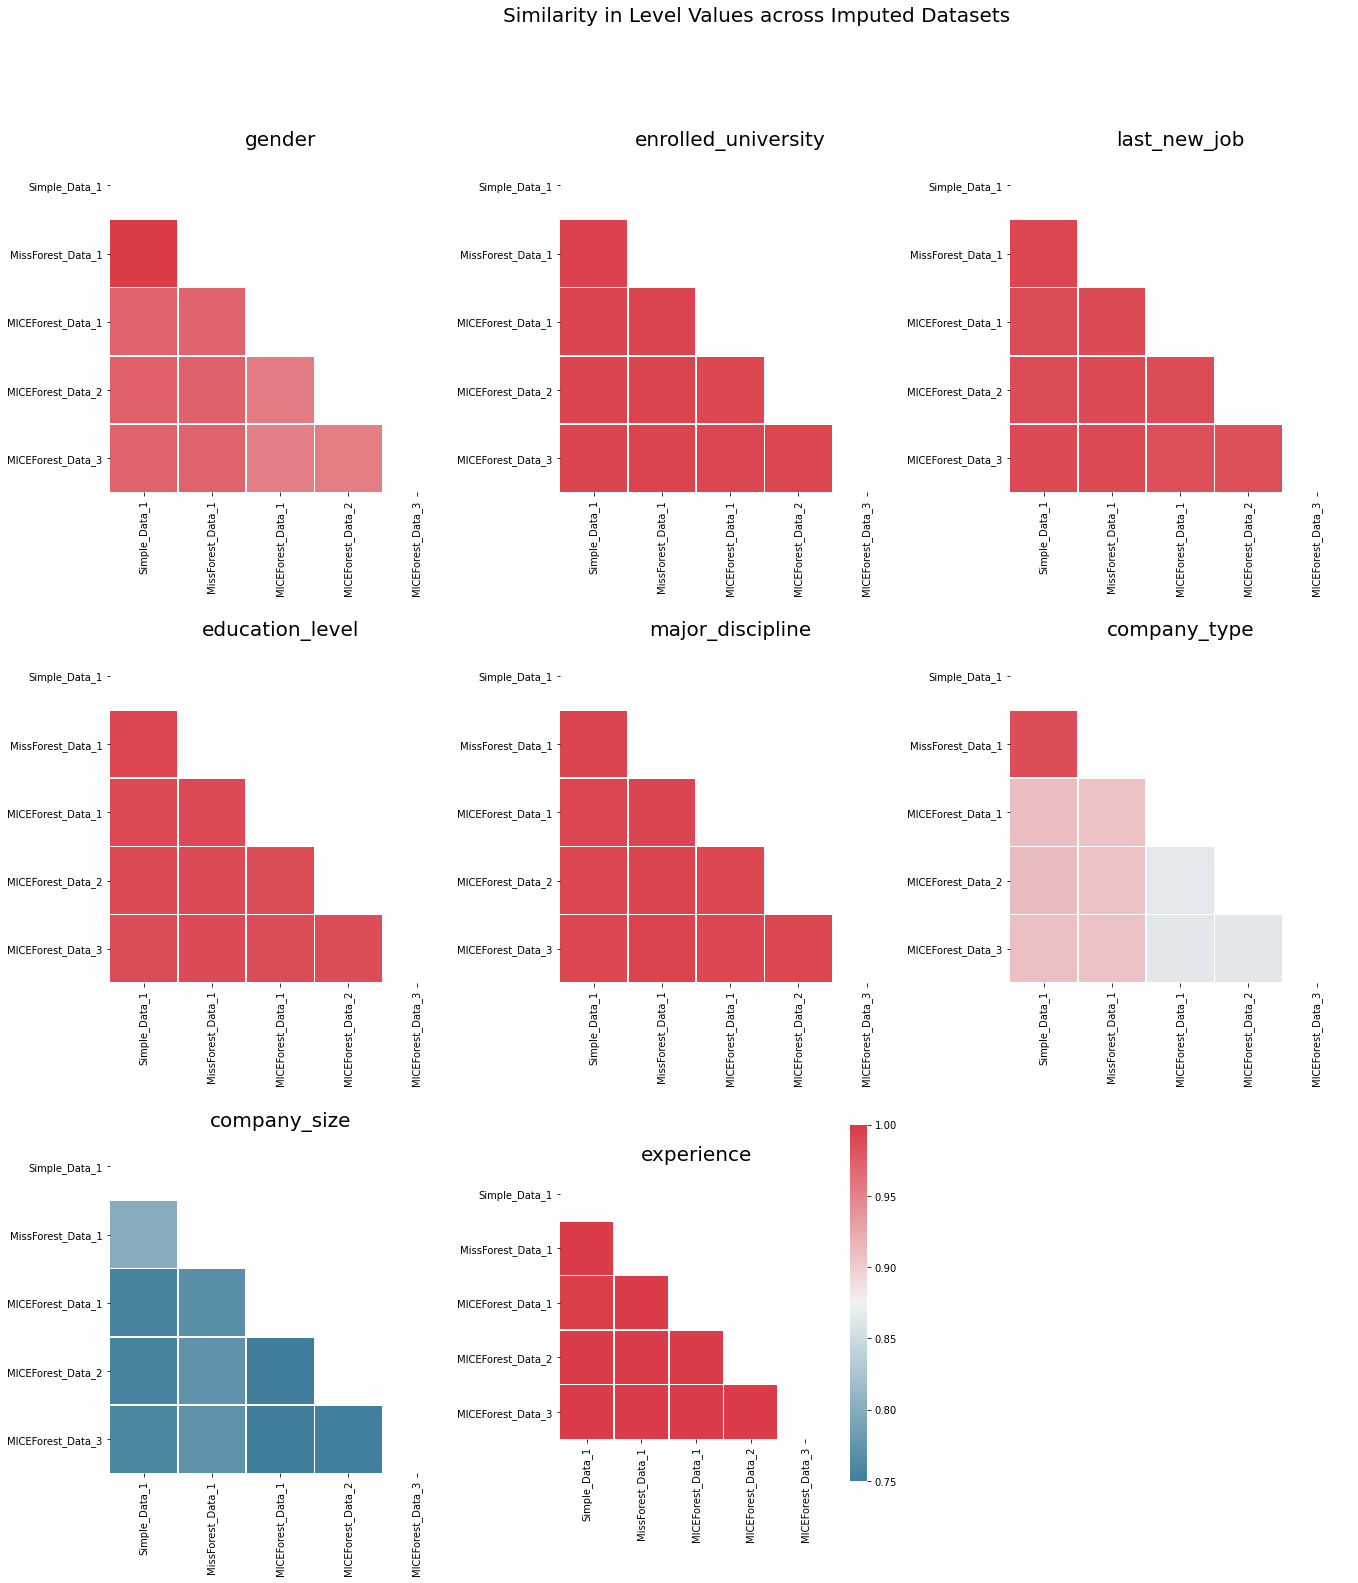

In [109]:
catvars_with_missing = ['gender','enrolled_university','last_new_job','education_level','major_discipline','company_type','company_size','experience']
imputed_all = [(key+'_'+'Data_'+str(counter+1), item) for key in imputed_data.keys() for counter, item in enumerate(imputed_data[key])] 
counter = len(imputed_all)

cmap = sns.diverging_palette(230, 10, as_cmap = True)
fig, ax = plt.subplots(3,3, figsize = (7*3, 7*3), sharex = True, sharey = True)
#cbar_ax = fig.add_axes(list(np.arange(0.70, 1.0, 0.1)))
for count, item in enumerate(catvars_with_missing):
    
    # Create a holder for the data
    newframe = np.zeros((counter, counter))
    
    # Now fill the data holder
    for i in np.arange(counter):
        for j in np.arange(counter):
            if(i>j):
                newframe[i,j] = sum((imputed_all[i][1][item]==imputed_all[j][1][item]).astype('int'))/len(imputed_all[0][1])
    
    newframe = pd.DataFrame(newframe, columns = [imputed_all[i][0] for i in np.arange(len(imputed_all))])
    newframe.index = [imputed_all[i][0] for i in np.arange(len(imputed_all))]
    
    mask = np.triu(np.ones_like(newframe, dtype = bool))
    plt.subplot(3, 3, count + 1)
    g = sns.heatmap(newframe, mask = mask, cmap = cmap, square = True, linewidth = 0.5, 
                    vmin = 0.75, vmax = 1.0, cbar = True if count==len(catvars_with_missing)-1 else False)
    g.set_title(item, fontsize = 20)

fig.delaxes(ax[2][2])
plt.suptitle('Similarity in Level Values across Imputed Datasets', fontsize = 20, y = 1.05)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()

The figure above shows that the imputed datasets are quite similar in most features, with more than 90% of similarity in level values in their observations. The only feature where the imputed datasets are marginally different is 'company_size'. In fact, even for the same type of imputation method - 'MICEForest', there are differences between the 3 imputations. However, even for this feature, over 75% of observation values are similar across imputed datasets. 

Next, we plot the level frequencies of each of these categorical features for different imputed datasets, and compare them to the level frequencies of the original dataset after dropping the missing values. 

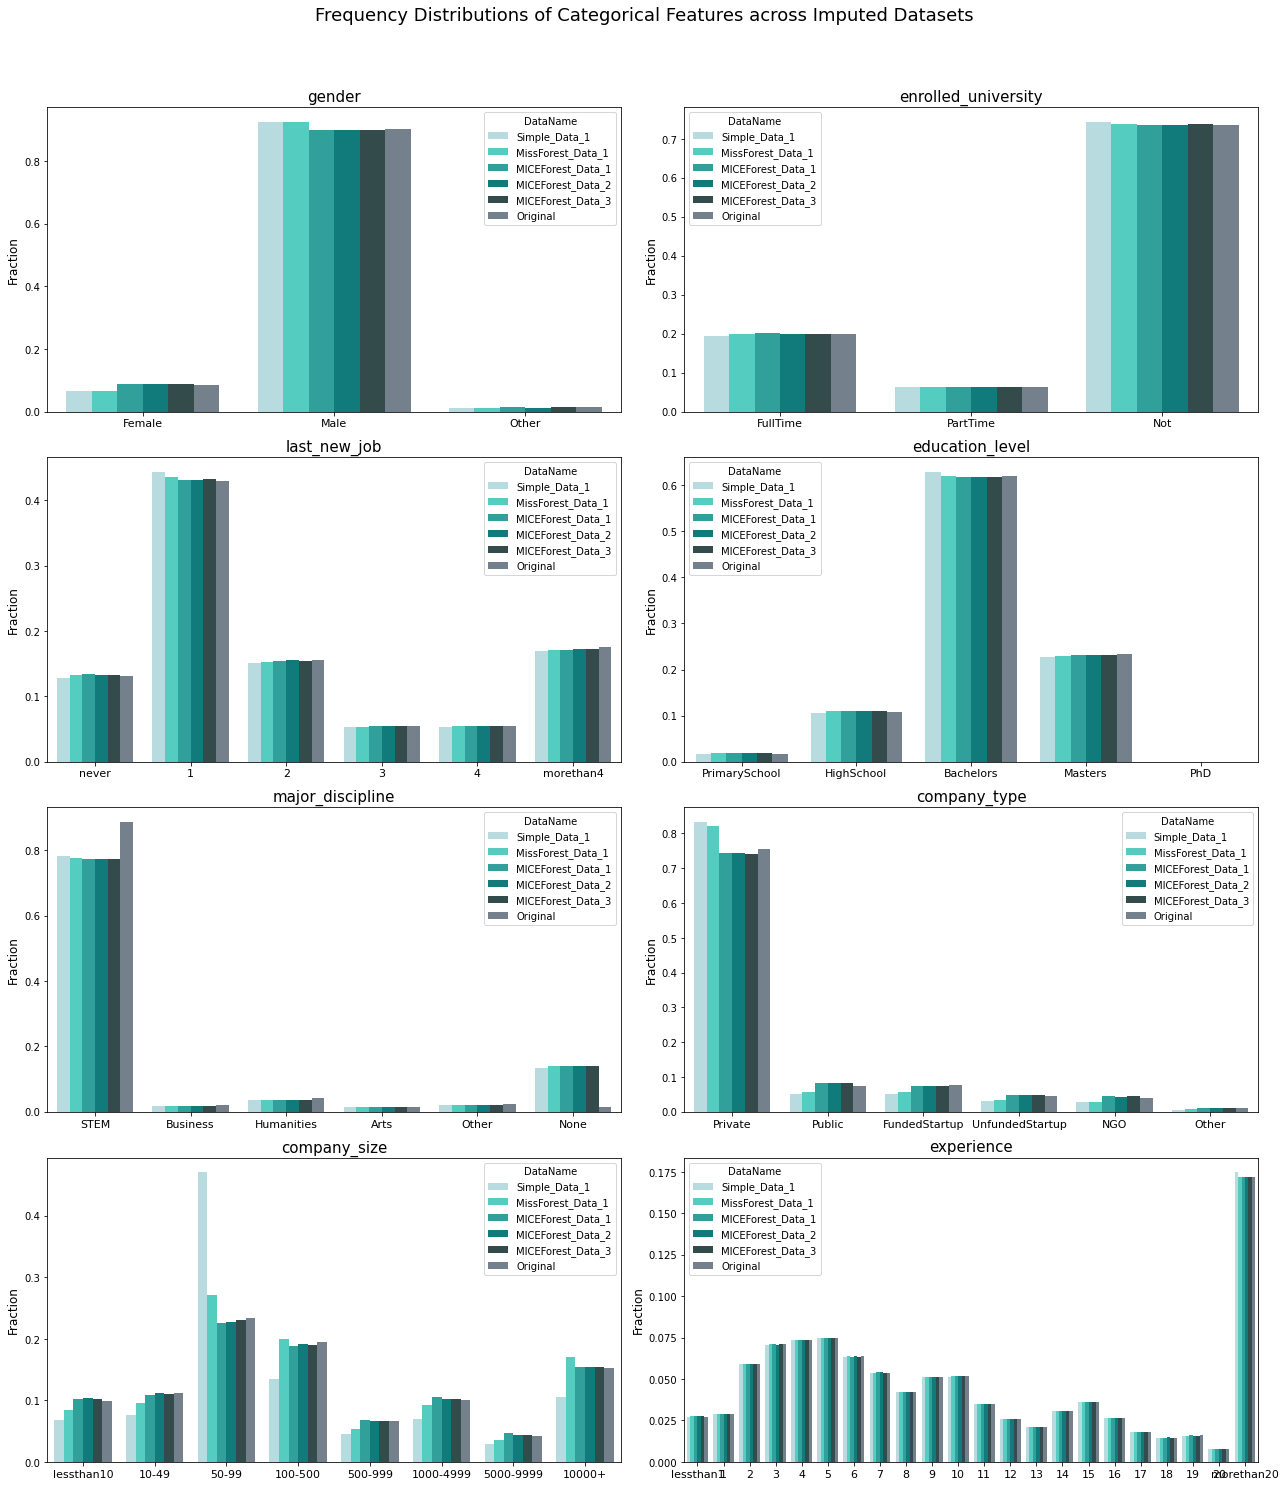

In [110]:
# Method used to plot:
    
#     1. For each data, count the fraction of observations in each level for a particular feature. 
#     2. Save each data-feature combination as a frame with dataname, featurename, fraction. 
#     3. Keep appending to the saved frame for each imputed dataset. 
#     4. Plot the above frame, ordering the levels as required. 
#     5. Do the same above for each feature. 

hue_order = [name for (name,_) in imputed_all]+['Original']
level_order = {'gender':['Female','Male','Other'], 
               'enrolled_university':['FullTime','PartTime','Not'], 
               'last_new_job':['never','1','2','3','4','morethan4'], 
               'education_level':['PrimarySchool','HighSchool','Bachelors','Masters','PhD'], 
               'major_discipline':['STEM','Business','Humanities','Arts','Other','None'], 
               'company_type':['Private','Public','FundedStartup','UnfundedStartup','NGO','Other'],
               'company_size':['lessthan10','10-49','50-99','100-500','500-999','1000-4999','5000-9999','10000+'], 
               'experience':['lessthan1']+[str(i) for i in np.arange(1,21,1)]+['morethan20']}
color = ['powderblue','turquoise','lightseagreen','darkcyan','darkslategray','slategrey']
leglabels = []

fig, ax = plt.subplots(4,2, figsize = (9*2, 5*4))
for counter, item in enumerate(catvars_with_missing):
    
    newframe = pd.DataFrame({item:[], 'Fraction':[], 'DataName':[]})
    for i, (name, frame) in enumerate(imputed_all):
        tempframe = (frame[item].value_counts()/len(frame)).reset_index()
        tempframe.columns = [item, 'Fraction']
        tempframe['DataName'] = [name for _ in np.arange(frame[item].nunique())]        
        newframe = pd.concat([newframe, tempframe], axis = 0, ignore_index = True)
        
    tempframe = (Data[item].value_counts(dropna = True)/len(Data.dropna(subset = [item], axis = 0, inplace = False))).reset_index()
    tempframe.columns = [item, 'Fraction']
    tempframe['DataName'] = ['Original' for _ in np.arange(Data.dropna(subset = [item], axis = 0, inplace = False)[item].nunique())]
    newframe = pd.concat([newframe, tempframe], axis = 0, ignore_index = True)    
    
    plt.subplot(4,2,counter+1)
    g = sns.barplot(data = newframe, x = item, y = 'Fraction', hue = 'DataName', order = level_order[item], palette = color)
    g.set_title(item, fontsize = 15)
    g.set_ylabel('Fraction', fontsize = 12)
    g.set_xlabel('')
    g.set_xticklabels(level_order[item], fontsize = 11)
plt.suptitle('Frequency Distributions of Categorical Features across Imputed Datasets', fontsize = 18, y = 1.03)    
plt.tight_layout()
plt.show()

del [newframe, tempframe]

#### Relationship between features and outcome variable

Method used:
1. Separately, standardize each imputed dataset and add it to the tuple.
2. Build a formula for running regressions. 
3. Run an LPM and Logistic Regression on each standardized dataset. 
4. Drop the intercept and the city levels from features and add it to a common dataframe. 
5. This frame has features as rows, and each model+dataset as column.
6. Order the rows based on LPM in Simple Imputed dataset. 
7. Plot the effects in the same graph, and show two different types of legends. 

In [111]:
# Define a formula 
baselevel_dict = {'city':'"103"',
                  'gender':'"Other"', 
                  'relevant_experience':'"No"', 
                  'last_new_job':'"never"', 
                  'company_type':'"Other"', 
                  'company_size':'"lessthan10"', 
                  'experience':'"lessthan1"', 
                  'major_discipline':'"None"', 
                  'education_level':'"PrimarySchool"', 
                  'enrolled_university':'"Not"'}
colnames = numvars + catvars
formula = 'target ~ '
for counter, item in enumerate(colnames):
    if(Data[item].dtypes.name == 'category'):
        formula = formula + 'C(' + str(item) + ', Treatment(reference = ' + str(baselevel_dict[item]) + '))'
    else:
        formula = formula + item
        
    if(counter < len(colnames)-1):
        formula = formula + ' + '      

# Generate a list of dummy variable to drop in the one-hot encoded case        
levels2drop = [key+'_'+re.search(r'"(.+?)"', value).group(1) for key, value in baselevel_dict.items()];         
        
        
print('Formula to be used for fitting linear and logistic regressions: \n')        
print(formula)

Formula to be used for fitting linear and logistic regressions: 

target ~ city_development_index + training_hours + C(city, Treatment(reference = "103")) + C(gender, Treatment(reference = "Other")) + C(relevant_experience, Treatment(reference = "No")) + C(enrolled_university, Treatment(reference = "Not")) + C(education_level, Treatment(reference = "PrimarySchool")) + C(major_discipline, Treatment(reference = "None")) + C(experience, Treatment(reference = "lessthan1")) + C(company_size, Treatment(reference = "lessthan10")) + C(company_type, Treatment(reference = "Other")) + C(last_new_job, Treatment(reference = "never"))


#### Linear Regression (or, Linear Probability Model)

This function does the following:
1. It takes in the dataset and formula to fit, alongside a name for the effects. 
2. It conducts the regression. 
3. Then it extracts the coefficients from the results. 
4. It drops all 'city' indicators. 
5. Then it creates a frame with remaining features, and effects and returns this frame. 

In [112]:
def conduct_LinearRegression(formula, dataset):
    
    # Fit the model
    model = smf.ols(data = dataset, formula = formula).fit()
    # Extract the model parameters
    modeleffects = model.params
    # Identify the features to keep
    keeplist = [item for item in modeleffects.index.to_list() if not item.startswith('Intercept') and not item.startswith('C(city,')]
    # Now pass the series back
    return modeleffects.loc[keeplist]


def conduct_LogisticRegression(dataset):
    
    # Fit the model
    model = LogisticRegression(penalty='none', fit_intercept=True).fit(dataset.drop(['target'], axis = 1), dataset['target'])    
    # Identify the features to keep
    keeplist = [(not item.startswith('city_') or item=='city_development_index') for item in dataset.drop(['target'], axis = 1).columns.to_list()]
    # Now use the derivative method to compute marginal effects
    a = np.sum(dataset.drop(['target'], axis = 1)*model.coef_[0], axis = 1)
    modeleffects = np.mean(np.exp(-a)/(1. + np.exp(-a))**2)*model.coef_[0]    
    # Return the correct series
    return pd.Series(modeleffects[keeplist], index = dataset.drop(['target'], axis = 1).columns[keeplist])

def modify_FeatureName(namelist):
    namelist = namelist.apply(lambda x: re.search(r'\((.+?),', x).group(1)+'_'+re.search(r'\.(.+?)\]',x).group(1) 
                              if re.search(r'\((.+?),', x) else x)
    return namelist

In [113]:
imputed_all_scaled = []

for counter, (name, frame) in enumerate(imputed_all):
    
    # First scale the data and add the scaled data to the tuple
    scaler = StandardScaler()
    tempframe = pd.DataFrame(scaler.fit(imputed_all[counter][1][numvars]).transform(imputed_all[counter][1][numvars]), 
                             columns = numvars)
    tempframe = pd.concat([tempframe, imputed_all[counter][1][catvars]], axis = 1, ignore_index = True)
    tempframe.columns = numvars + catvars    
    imputed_all_scaled.append((name, tempframe))
    tempframe = pd.concat([Data['target'], tempframe], axis = 1, ignore_index = True)
    tempframe.columns = ['target'] + numvars + catvars
    
    # Now conduct the linear regression and get back the estimates
    effects = conduct_LinearRegression(formula, tempframe)
    
    if(counter == 0):
        model_Effects = pd.DataFrame(effects).reset_index()
        model_Effects.columns = ['Feature', 'Linear_'+name]
        model_Effects['Feature'] = list(modify_FeatureName(model_Effects['Feature']))
    else:    
        temp_Effects = pd.DataFrame(effects).reset_index()
        temp_Effects.columns = ['Feature', 'Linear_'+name]
        temp_Effects['Feature'] = list(modify_FeatureName(temp_Effects['Feature']))
        model_Effects = model_Effects.merge(temp_Effects, on = 'Feature')
      
        
    # Now transform the data for conducting Logistic regression
    tempframe = pd.get_dummies(tempframe, drop_first= False)
    tempframe.drop(levels2drop, axis = 1, inplace = True)
    
    # Now conduct the logistic regression
    effects = conduct_LogisticRegression(tempframe)
    #print(effects)
    temp_Effects = pd.DataFrame(effects).reset_index()
    temp_Effects.columns = ['Feature', 'Logistic_'+name]
    model_Effects = model_Effects.merge(temp_Effects, on = 'Feature')     

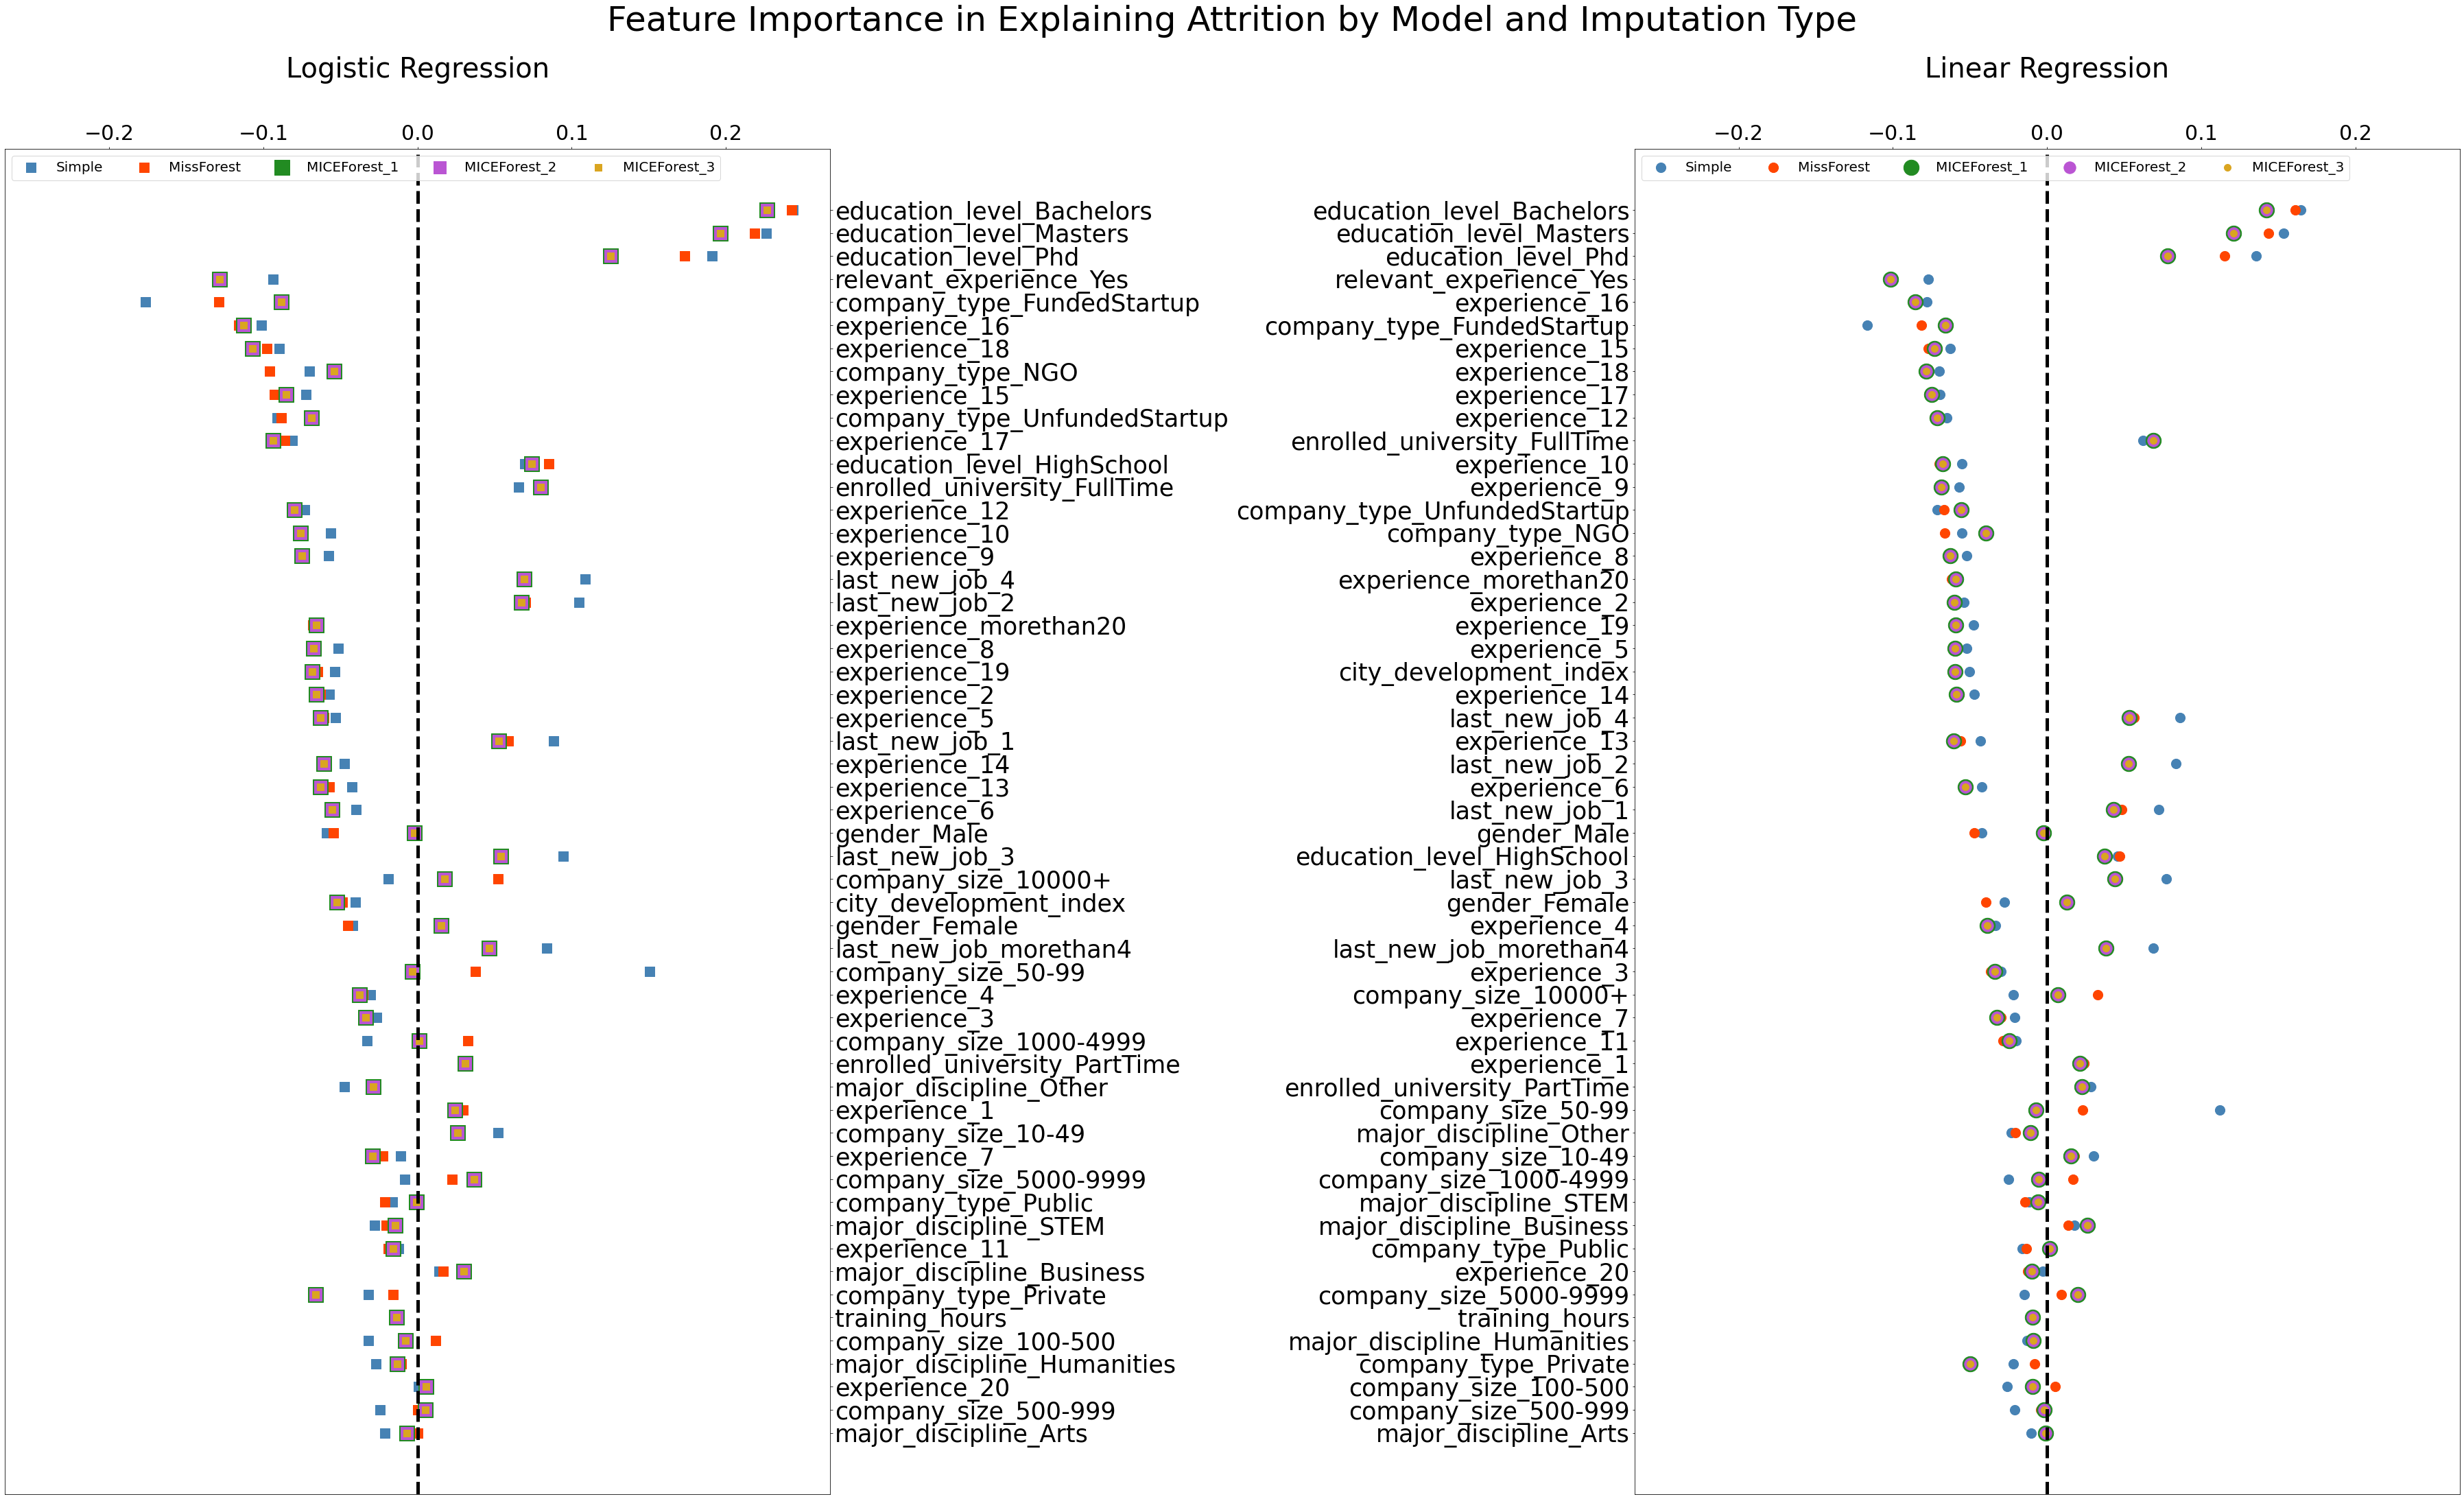

In [114]:
# Now plot the graphs

model_Effects = model_Effects.iloc[(model_Effects['Logistic_MissForest_Data_1'].abs()).argsort()]
maxlimit = max(max([max(model_Effects['Logistic_'+name].abs()) for name,_ in imputed_all]), 
               max([max(model_Effects['Linear_'+name].abs()) for name,_ in imputed_all]))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (50, 30))
#plt.subplot(1,2,1)
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_Simple_Data_1'], marker = 's', s = 200, color = 'steelblue', label = 'Simple')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MissForest_Data_1'], marker = 's', s = 200, color = 'orangered', label = 'MissForest')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MICEForest_Data_1'], marker = 's', s = 500, color = 'forestgreen', label = 'MICEForest_1')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MICEForest_Data_1'], marker = 's', s = 300, color = 'mediumorchid', label = 'MICEForest_2')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MICEForest_Data_1'], marker = 's', s = 100, color = 'goldenrod', label = 'MICEForest_3')
ax1.axvline(x = 0., linestyle = '--', color = 'black', linewidth = 5)
ax1.set_yticklabels(model_Effects['Feature'], fontsize = 35)
ax1.tick_params(axis = 'x', labelsize = 30)
ax1.set_ylabel('')
ax1.yaxis.tick_right()
ax1.xaxis.tick_top()
ax1.set_title('Logistic Regression', fontsize = 40, y = 1.05)
ax1.set_xlim(-maxlimit-maxlimit/10., maxlimit+maxlimit/10.)
ax1.legend(loc = 'upper left', ncol = 5, prop={'size': 20});


model_Effects = model_Effects.iloc[model_Effects['Linear_MissForest_Data_1'].abs().argsort()]
#plt.subplot(1,2,2)
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_Simple_Data_1'], marker = 'o', s = 200, color = 'steelblue', label = 'Simple')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MissForest_Data_1'], marker = 'o', s = 200, color = 'orangered', label = 'MissForest')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MICEForest_Data_1'], marker = 'o', s = 500, color = 'forestgreen', label = 'MICEForest_1')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MICEForest_Data_1'], marker = 'o', s = 300, color = 'mediumorchid', label = 'MICEForest_2')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MICEForest_Data_1'], marker = 'o', s = 100, color = 'goldenrod', label = 'MICEForest_3')
ax2.axvline(x = 0., linestyle = '--', color = 'black', linewidth = 5)
ax2.set_yticklabels(model_Effects['Feature'], fontsize = 35)
ax2.tick_params(axis = 'x', labelsize = 30)
ax2.set_ylabel('')
ax2.xaxis.tick_top()
ax2.set_title('Linear Regression', fontsize = 40, y = 1.05)
ax2.set_xlim(-maxlimit-maxlimit/10., maxlimit+maxlimit/10.)
ax2.legend(loc = 'upper left', ncol = 5, prop={'size': 20});

plt.suptitle('Feature Importance in Explaining Attrition by Model and Imputation Type', fontsize = 50, y = 1.01)
plt.tight_layout()
plt.show()

### Things to keep in mind:

* Choose the same training and test sets across impuated datasets. 
* Choose train and test sets, both using regular method and imbalanced learn. 

#### Create unbalanced train and test sets

In [62]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(imputed_all_scaled[1][1], Data['target'], test_size = 0.2, random_state = seed)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

catindices = np.where(Xtrain.dtypes != np.float)[0] 

model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42)
model.fit(
    Xtrain, Ytrain,
    cat_features=catindices,
    verbose = 0 
#     logging_level='Verbose',  # you can uncomment this for text output
    #plot=True
);

(15326, 12) (3832, 12) (15326,) (3832,)


In [127]:
# Define a function for each classifier

def Logistic_Classifier(trainX, testX, trainY, testY):
    
    # Now fit the default Logistic Regression
    logreg = LogisticRegression()
    model = logreg.fit(trainX, trainY)
    
    # Now predict the test labels
    Ypred = model.predict(testX)
    accuracy = accuracy_score(testY, Ypred)
    precision = precision_score(testY, Ypred)
    recall = recall_score(testY, Ypred)
    f1score = f1_score(testY, Ypred)
    rocauc = roc_auc_score(testY, Ypred)
    
    return accuracy, precision, recall, f1score, rocauc

def XGBoost_Classifier(trainX, testX, trainY, testY):
    
    # Now fit the default Logistic Regression
    xgbc = XGBClassifier(verbosity = 0)
    model = xgbc.fit(trainX, trainY)
    
    # Now predict the test labels
    Ypred = model.predict(testX)
    accuracy = accuracy_score(testY, Ypred)
    precision = precision_score(testY, Ypred)
    recall = recall_score(testY, Ypred)
    f1score = f1_score(testY, Ypred)
    rocauc = roc_auc_score(testY, Ypred)
    
    return accuracy, precision, recall, f1score, rocauc

def CatBoost_Classifier(trainX, testX, trainY, testY):
    
    # Recognize the categorical indices
    catindices = [counter for counter, item in enumerate(trainX.columns.to_list()) if trainX[item].dtypes.name == 'category']  
    
    # Now fit the default Logistic Regression
    cbc = CatBoostClassifier(verbose = 0)
    model = cbc.fit(trainX, trainY, cat_features=catindices) 
    
    # Now predict the test labels
    Ypred = model.predict(testX)
    accuracy = accuracy_score(testY, Ypred)
    precision = precision_score(testY, Ypred)
    recall = recall_score(testY, Ypred)
    f1score = f1_score(testY, Ypred)
    rocauc = roc_auc_score(testY, Ypred)
    
    return accuracy, precision, recall, f1score, rocauc

def AdaBoost_Classifier(trainX, testX, trainY, testY):
    
    # Now fit the default Logistic Regression
    abc = AdaBoostClassifier()
    model = abc.fit(trainX, trainY)
    
    # Now predict the test labels
    Ypred = model.predict(testX)
    accuracy = accuracy_score(testY, Ypred)
    precision = precision_score(testY, Ypred)
    recall = recall_score(testY, Ypred)
    f1score = f1_score(testY, Ypred)
    rocauc = roc_auc_score(testY, Ypred)
    
    return accuracy, precision, recall, f1score, rocauc
    

In [132]:
samplingtypes = ['Unbalanced', 'OverSampling', 'UnderSampling', 'SMOTE']
classifiertypes = ['Logistic', 'XGBoost', 'CatBoost', 'AdaBoost']
modeltypes = [];
modeltypes = [str1+'_'+str2 for str1 in classifiertypes for str2 in samplingtypes];
metricslist = ['accuracy','precision','recall','f1score','rocauc'];

testmetrics = {}
testmetrics['accuracy'] = {k:[] for k in modeltypes} 
for metric in metricslist[1:]:
    testmetrics[metric] = copy.deepcopy(testmetrics['accuracy'])    
    
seed = 503 
test_size = 0.2




# Iterate over the list of models (classifier-sampling)
for counter1, modeltype in enumerate(modeltypes):
    
    # Iterate over the samples    
    for counter2, (name, frame) in enumerate(imputed_all_scaled):
        
        classifiertype = modeltype.split('_')[0]
        samplingtype = modeltype.split('_')[1]
        
        # Dummify the data 
        frame = pd.get_dummies(frame, drop_first = False)
            
        print('Classification in process', '--- Classifier:', classifiertype, '--- Sampling:', samplingtype, '--- Data:', name, '.....')  
        
        # Split the data if required or use previously stored indices to split
        if(counter1 == 0 and counter2 == 0):
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(frame, Data['target'], 
                                                            test_size = test_size, random_state = seed)
            trainindex = Xtrain.index.to_list()
            testindex = Xtest.index.to_list()
        else:
            Xtrain = frame.loc[trainindex,:]
            Xtest = frame.loc[testindex,:]
            Ytrain = Data['target'].loc[trainindex]
            Ytest = Data['target'].loc[testindex]
            
        # Now sample according to the sample type        
        if(samplingtype != 'Unbalanced'): 
            if(samplingtype == 'OverSampling'):
                Xtrain, Ytrain = RandomOverSampler().fit_resample(Xtrain, Ytrain) 
            elif(samplingtype == 'UnderSampling'):
                Xtrain, Ytrain = RandomUnderSampler().fit_resample(Xtrain, Ytrain)
            else:
                Xtrain, Ytrain = SMOTE().fit_resample(Xtrain, Ytrain)
                
        # Now send the data to train and output prediction metrics to the right function
        if(classifiertype == 'Logistic'):            
            accuracy, precision, recall, f1score, rocauc = Logistic_Classifier(Xtrain, Xtest, Ytrain, Ytest)
            
        elif(classifiertype == 'XGBoost'):
            accuracy, precision, recall, f1score, rocauc = XGBoost_Classifier(Xtrain, Xtest, Ytrain, Ytest)            
            
        elif(classifiertype == 'CatBoost'):
            accuracy, precision, recall, f1score, rocauc = CatBoost_Classifier(Xtrain, Xtest, Ytrain, Ytest)            
            
        else:    
            accuracy, precision, recall, f1score, rocauc = AdaBoost_Classifier(Xtrain, Xtest, Ytrain, Ytest)            
        
        # Now record the metrics
        testmetrics['accuracy'][modeltype].append(accuracy)
        testmetrics['precision'][modeltype].append(precision)
        testmetrics['recall'][modeltype].append(recall)
        testmetrics['f1score'][modeltype].append(f1score)
        testmetrics['rocauc'][modeltype].append(rocauc)


 

Classification in process --- Classifier: Logistic --- Sampling: Unbalanced --- Data: Simple_Data_1 .....
Classification in process --- Classifier: Logistic --- Sampling: Unbalanced --- Data: MissForest_Data_1 .....
Classification in process --- Classifier: Logistic --- Sampling: Unbalanced --- Data: MICEForest_Data_1 .....
Classification in process --- Classifier: Logistic --- Sampling: Unbalanced --- Data: MICEForest_Data_2 .....
Classification in process --- Classifier: Logistic --- Sampling: Unbalanced --- Data: MICEForest_Data_3 .....
Classification in process --- Classifier: Logistic --- Sampling: OverSampling --- Data: Simple_Data_1 .....
Classification in process --- Classifier: Logistic --- Sampling: OverSampling --- Data: MissForest_Data_1 .....
Classification in process --- Classifier: Logistic --- Sampling: OverSampling --- Data: MICEForest_Data_1 .....
Classification in process --- Classifier: Logistic --- Sampling: OverSampling --- Data: MICEForest_Data_2 .....
Classifica

Classification in process --- Classifier: AdaBoost --- Sampling: SMOTE --- Data: Simple_Data_1 .....
Classification in process --- Classifier: AdaBoost --- Sampling: SMOTE --- Data: MissForest_Data_1 .....
Classification in process --- Classifier: AdaBoost --- Sampling: SMOTE --- Data: MICEForest_Data_1 .....
Classification in process --- Classifier: AdaBoost --- Sampling: SMOTE --- Data: MICEForest_Data_2 .....
Classification in process --- Classifier: AdaBoost --- Sampling: SMOTE --- Data: MICEForest_Data_3 .....


In [135]:
# For each model and training set type, average over the MICEForest metrics and add a new element to the list 

for metric in metricslist:
    for modeltype in modeltypes:    
        testmetrics[metric][modeltype].append(statistics.mean(testmetrics[metric][modeltype][-3:]))
        
## Check that the lengths of each list is now 6
for key1 in testmetrics.keys():
    for key2 in testmetrics[key1].keys():
        if(len(testmetrics[key1][key2]) != 6):
            print(key1, key2)

#### Imbalanced Learning

Here, I use the same train and test sets as before. However, instead of training the data on the original train set, which is imbalanced, I will use different techniques to create balanced training sets from the original train set. The models will however be evaluated on the same imbalanced test set. 

In [144]:
alldict = copy.deepcopy(testmetrics)

frame = pd.DataFrame(alldict['accuracy']).iloc[[0,1,5],:]
frame.index = ['Simple','MissForest','MICEForest'] 
frame

,Logistic_Unbalanced,Logistic_OverSampling,Logistic_UnderSampling,Logistic_SMOTE,XGBoost_Unbalanced,XGBoost_OverSampling,XGBoost_UnderSampling,XGBoost_SMOTE,CatBoost_Unbalanced,CatBoost_OverSampling,CatBoost_UnderSampling,CatBoost_SMOTE,AdaBoost_Unbalanced,AdaBoost_OverSampling,AdaBoost_UnderSampling,AdaBoost_SMOTE
Simple,0.776357,0.746868,0.742432,0.772965,0.773225,0.743998,0.731472,0.757829,0.773486,0.750522,0.739562,0.769833,0.773225,0.743476,0.740344,0.753132
MissForest,0.775835,0.744781,0.740605,0.781315,0.769833,0.731733,0.711117,0.760177,0.776357,0.746608,0.732516,0.772965,0.776879,0.747912,0.740084,0.744520
MICEForest,0.777488,0.741997,0.738779,0.780097,0.769050,0.740084,0.706681,0.769572,0.776531,0.751131,0.734342,0.777836,0.780358,0.748521,0.741997,0.762265


In [136]:
for key1 in testmetrics.keys():
    with open(os.path.join(sourcepath,'reports','Metrics_'+key1+'.csv'), 'w') as f:
        writer = csv.writer(f)
        for k,v in testmetrics[key1].items():
            writer.writerow([k,v])

In [161]:
frame = pd.DataFrame(testmetrics[item]).iloc[[0,1,5],:].transpose()
frame.columns = colnames
frame

,Simple,MissForest,MICEForest
Logistic_Unbalanced,0.776357,0.775835,0.777488
Logistic_OverSampling,0.746868,0.744781,0.741997
Logistic_UnderSampling,0.742432,0.740605,0.738779
Logistic_SMOTE,0.772965,0.781315,0.780097
XGBoost_Unbalanced,0.773225,0.769833,0.769050
XGBoost_OverSampling,0.743998,0.731733,0.740084
XGBoost_UnderSampling,0.731472,0.711117,0.706681
XGBoost_SMOTE,0.757829,0.760177,0.769572
CatBoost_Unbalanced,0.773486,0.776357,0.776531
CatBoost_OverSampling,0.750522,0.746608,0.751131


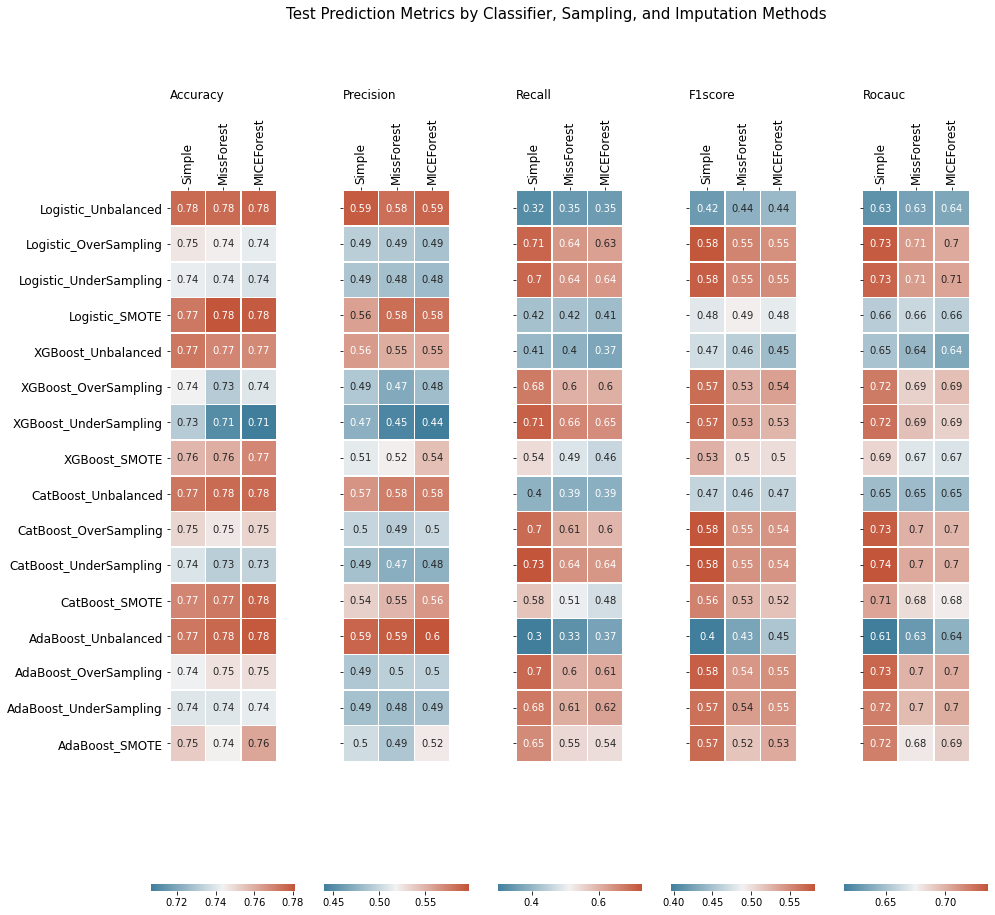

In [193]:
# Convert the metrics dictionaries into dataframes to plot

fig, ax = plt.subplots(1, len(metricslist), figsize = (15,15), sharey = True)
colnames = ['Simple','MissForest','MICEForest']

for counter, item in enumerate(metricslist):
    
    frame = pd.DataFrame(testmetrics[item]).iloc[[0,1,5],:].transpose()
    frame.columns = colnames
    cmap = sns.diverging_palette(230, 20, as_cmap = True) 
    g = sns.heatmap(frame, cmap = cmap, vmax = max(frame.max()), vmin = min(frame.min()), annot = True, 
                    square = True, linewidth = 0.5, ax = ax[counter], 
                    cbar_kws={"shrink": 1.,
                              "use_gridspec":False,"location":"bottom" 
                              #"location":"bottom"
                             })
    g.set_title(item.capitalize(), fontsize = 12, y = 1.15, loc = 'left')
    ax[counter].xaxis.tick_top()   
    ax[counter].set_xticklabels(colnames, rotation = 90, fontsize = 12)
    ax[counter].set_yticklabels(modeltypes, fontsize = 12)
plt.suptitle('Test Prediction Metrics by Classifier, Sampling, and Imputation Methods', fontsize = 15, y = 1.05);
plt.savefig(os.path.join(sourcepath, 'reports', 'figures', 'PredictionMetricsComparison.png'), bbox_inches = 'tight')


In [197]:
## Now for each metric, find the classifier, sampling type, and imputation type that gives the maximum value:


colnames = ['Simple','MissForest','MICEForest1','MICEForest2','MICEForest3','MICEForest']
maxmodel = ('imputation', 'sampling', 'classifier')
for metric in metricslist:
    maxval = 0.
    for key in testmetrics[metric].keys():
        for val in [0,1,5]:
            if(testmetrics[metric][key][val] > maxval):
                maxval = testmetrics[metric][key][val]
                maxmodel = (colnames[val], key.split('_')[1], key.split('_')[0])
    print('Maximum',metric,'of:',round(maxval,3),'achieved with -- Imputation Type:',maxmodel[0], 'Sampling Type:',maxmodel[1],'Classifier:',maxmodel[2])            

Maximum accuracy of: 0.781 achieved with -- Imputation Type: MissForest Sampling Type: SMOTE Classifier: Logistic
Maximum precision of: 0.597 achieved with -- Imputation Type: MICEForest Sampling Type: Unbalanced Classifier: AdaBoost
Maximum recall of: 0.729 achieved with -- Imputation Type: Simple Sampling Type: UnderSampling Classifier: CatBoost
Maximum f1score of: 0.583 achieved with -- Imputation Type: Simple Sampling Type: OverSampling Classifier: CatBoost
Maximum rocauc of: 0.736 achieved with -- Imputation Type: Simple Sampling Type: UnderSampling Classifier: CatBoost
